In [27]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
import numpy as np


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, p):
        m, n = X.shape
        q = compute_q(p)
        # Formulate problem
        param = cp.Variable(n)
        param_norm = cp.pnorm(param, p=q)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-3):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-3, n_alphas=200):
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def multiple_imputation(nbr_mi, X_nan):
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer()
       ice_mean = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res = ice_mean.fit_transform(X_nan)
       #print("fin res ", res)
       return res

#X, y = datasets.load_diabetes(return_X_y=True)
#print(X.shape, y.shape)
# Standardize data

n = 100
d = 10
X = np.random.rand(n, d)
X -= X.mean(axis=0)
X /= X.std(axis=0)
b = np.random.rand(d)
y = X @ b

masks = np.random.binomial(1, 0.1, (n, d))  # 1 missing, 0 seen
#M = np.sum(masks, axis=1)
X_nan = X.copy()
X_nan[masks == 1] = np.nan

X = multiple_imputation(1, X_nan)
print("end block")


end block


 98%|█████████▊| 197/200 [00:09<00:00,  3.23it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:10<00:00, 19.15it/s]


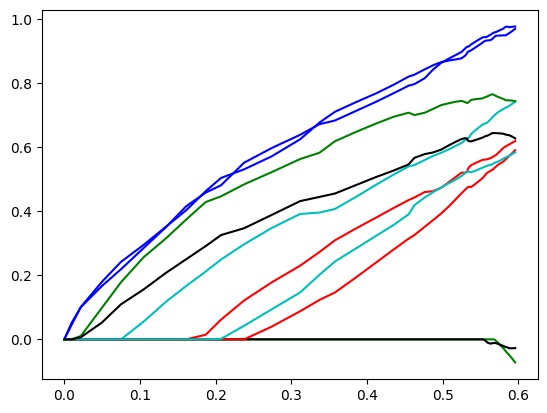

In [28]:
fig, ax = plt.subplots(num='advtrain_linf')
linfadvtrain = AdversarialTraining(X, y, p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)

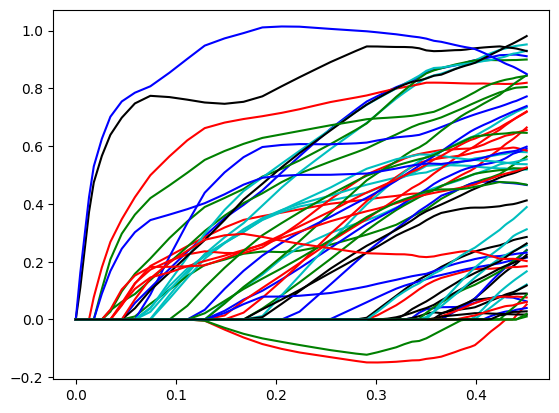

In [25]:
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X, y)
plot_coefs_l1norm(coefs_lasso, ax)